In [1]:
import os
import pandas as pd
import numpy as np
import sys
import re
import logging
from Modules.Loader_wrangler import *
import random
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Configure basic logging
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)s: %(message)s')

In [ ]:
play = loader(output_file_name="merged_df2017.pkl", chunksize=100000, sample_size=100000, survey_year=2017)

In [3]:
play = pd.read_pickle("/home/trapfishscott/Cambridge24.25/D200_ML_econ/ProblemSets/Project/data/merged_df2017.pkl")

### Obtaining only relevant variables and making into a time series

## Data Manipulation pipeline

1. One-hot encode categorical features + any small cleaning steps
2. Add days of the week with no car travel
3. Make data frame into wide format
4. Convert to tensor

* Includes JourSeq gaps if trips were made by non-car inbetween

In [ ]:
### small cleaning steps and one hot encoding

In [4]:
#temporal_vars = ["TWSMonth", "TravelYear", "TravelWeekDay_B01ID"]
#individual_vars =["PSUGOR_B02ID", "IndIncome2002_B02ID", "HHoldNumChildren", "DVLALengthBand_B01ID"]

numerical_outcome_vars = ["TripStart", "TripEnd", "TripDisExSW"]
categorical_outcome_vars = ["TripPurpose_B01ID"]

## Going to make all one hot...
new_vars = ['ParkWk_B01ID', # where do you usually park (onehot)   -8.-9.-10 bad values
            'OftHome_B01ID', #How often do you work at home (numerical)  -8.-9.-10 bad values
            'WkLift_B01ID', #How often do you give/receive lift from a work colleague when travelling to work (numerical) -8.-9.-10 bad values
            'IndWkGOR_B02ID', #Region of usual work place (onehot) bad values...
            'EcoStat_B02ID',#Working status of individual (onehot) bad values
            'PossHmN_B01ID', #Is it possible work at home instead of travelling to work (numerical?) bad values
            'PDrivSt_B01ID'] #Whether currently learning to drive (onehot) bad values

extra_vars = ["IndividualID_x", "JourSeq"]
features_one_hot = ["PSUGOR_B02ID", "ParkWk_B01ID", "OftHome_B01ID", "WkLift_B01ID", 'IndWkGOR_B02ID',
                     "EcoStat_B02ID", "PossHmN_B01ID", 'PDrivSt_B01ID',
                     "HHoldNumChildren", "IndIncome2002_B02ID", "DVLALengthBand_B01ID"]
features_numerical = ["TravelYear"]
features_cyclical = ["TWSMonth", "TravelWeekDay_B01ID"]

features = features_one_hot + features_numerical + features_cyclical
outcomes = numerical_outcome_vars + categorical_outcome_vars

In [5]:
ts_df = play[features + outcomes + extra_vars]

In [6]:
ts_df

,PSUGOR_B02ID,ParkWk_B01ID,OftHome_B01ID,WkLift_B01ID,IndWkGOR_B02ID,EcoStat_B02ID,PossHmN_B01ID,PDrivSt_B01ID,HHoldNumChildren,IndIncome2002_B02ID,DVLALengthBand_B01ID,TravelYear,TWSMonth,TravelWeekDay_B01ID,TripStart,TripEnd,TripDisExSW,TripPurpose_B01ID,IndividualID_x,JourSeq
0,1.0,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,0.0,2.0,12.0,2017.0,8.0,7.0,1073.0,1083.0,2.6,23.0,2.017009e+09,3.0
1,1.0,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,0.0,2.0,12.0,2017.0,8.0,4.0,633.0,647.0,3.2,23.0,2.017009e+09,1.0
2,1.0,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,0.0,2.0,12.0,2017.0,8.0,6.0,1241.0,1251.0,2.7,23.0,2.017009e+09,4.0
3,2.0,6.0,7.0,1.0,2.0,1.0,4.0,-9.0,2.0,1.0,16.0,2017.0,5.0,5.0,990.0,1020.0,6.0,1.0,2.017005e+09,2.0
4,2.0,6.0,7.0,1.0,2.0,1.0,4.0,-9.0,2.0,1.0,16.0,2017.0,5.0,3.0,600.0,625.0,6.0,1.0,2.017005e+09,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98585,4.0,6.0,7.0,7.0,4.0,2.0,4.0,-9.0,0.0,1.0,16.0,2017.0,10.0,1.0,915.0,930.0,7.0,21.0,2.017012e+09,7.0
98586,4.0,6.0,7.0,7.0,4.0,2.0,4.0,-9.0,0.0,1.0,16.0,2017.0,10.0,4.0,990.0,1000.0,7.0,21.0,2.017012e+09,5.0
98587,4.0,7.0,7.0,7.0,-9.0,2.0,4.0,-9.0,0.0,2.0,16.0,2017.0,10.0,4.0,720.0,730.0,1.6,9.0,2.017012e+09,2.0
98588,4.0,7.0,7.0,7.0,-9.0,2.0,4.0,-9.0,0.0,2.0,16.0,2017.0,10.0,6.0,1300.0,1320.0,1.1,9.0,2.017012e+09,4.0


### Encoders

In [7]:
# Cyclical encoder

def apply_cyclical_encoding(column, type_, max_val):

    if type_ == "cos":
        return np.cos(2 * np.pi * column/ max_val)
    else:
        return np.sin(2 * np.pi * column/ max_val)


def custom_numerical_scaler(x, x_min, x_max, inverse=False):
    if not inverse:
        x_scaled = (x-x_min)/(x_max - x_min)
        return x_scaled
    else:
        x_unscaled = x*(x_max - x_min) + x_min
        return x_unscaled


standard_mms = MinMaxScaler()

def log_transformer(x, inverse=False):
    if not inverse:
        return np.log1p(x)
    else:
        return np.expm1(x)
    
# Apply one-hot to categorical
ohe = OneHotEncoder(sparse_output=False)


In [8]:
# Apply cyclical encoding to cyclical column

ts_df.loc[:, "TravelWeekDay_B01ID"] = ts_df.loc[:, "TravelWeekDay_B01ID"].astype(int)

standard_mms.fit_transform(ts_df[features_numerical])

# Careful not to run twice

for col in features_one_hot:
    ts_df[col] = ts_df[col].astype(int)

ohe.fit_transform(ts_df[features_one_hot])


/tmp/ipykernel_18549/625541135.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df[col] = ts_df[col].astype(int)
/tmp/ipykernel_18549/625541135.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df[col] = ts_df[col].astype(int)
/tmp/ipykernel_18549/625541135.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Imputing missing travel days

In [9]:
def impute_missing_travel_week_for_i(i_df, i_id, full_week_encoding, features=features, outcomes=outcomes):
        
    break_flag = False

    # Travel days with travel 
    included_travel_day = i_df["TravelWeekDay_B01ID"].to_list()

    # Travel days with no travel
    travel_day_no_drive = list(set(full_week_encoding) - set(included_travel_day))

    # These values will repeat for empty-travel travel days
    imputed_travel_df = pd.DataFrame({
        "TravelWeekDay_B01ID": travel_day_no_drive,
        "IndividualID_x": [i_id]*len(travel_day_no_drive),
        "JourSeq": [1]*len(travel_day_no_drive)
    })


    
    # Looping through all the columns in the original df
    for col in i_df.columns:

        # For days with no travel all outcomes vars will take 0
        if col in outcomes:
            imputed_travel_df[col] = [0]*len(travel_day_no_drive)

    
        else:
        
            if col not in extra_vars + ["TravelWeekDay_B01ID"]:
                if len(i_df[col].unique()) != 1:
                    print(f"{col} is erroneous for {i_id}")
                    print(f"Unique vals: {i_df[col].unique()}")
                    break_flag = True
                    break
                else:
                    imputed_travel_df[col] = i_df[col].unique()[0]

    if break_flag:
        print("Continuing to next individual")
        return
    

    #display(imputed_travel_df)
    #display(i_df)

    # Merging on IndividualID_x and TravelWeekDay_B01ID
    #full_df = i_df.merge(imputed_travel_df, on=["IndividualID_x", "TravelWeekDay_B01ID"], how="left")

    # Concatenating df to include empty travel days
    full_df = pd.concat([i_df, imputed_travel_df])
    #display(full_df)

    full_df = full_df.sort_values(["TravelYear", "TWSMonth", "TravelWeekDay_B01ID", "JourSeq", "TripStart", "TripEnd"])

    full_df.loc[:, "TWSMonth_cos"] = apply_cyclical_encoding(column=full_df["TWSMonth"], type_="cos", max_val=12)
    full_df.loc[:, "TWSMonth_sin"] = apply_cyclical_encoding(column=full_df["TWSMonth"], type_="sin", max_val=12)

    full_df.loc[:, "TravelWeekDay_B01ID_cos"] = apply_cyclical_encoding(column=full_df["TravelWeekDay_B01ID"], type_="cos", max_val=7)
    full_df.loc[:, "TravelWeekDay_B01ID_sin"] = apply_cyclical_encoding(column=full_df["TravelWeekDay_B01ID"], type_="sin", max_val=7)

    if full_df["TripStart"].max() > 1.5:
        full_df.loc[:,"TripStart"] = full_df["TripStart"].apply(lambda x: custom_numerical_scaler(x, x_max=60*24, x_min=0))

    if full_df["TripEnd"].max() > 1.5:
        full_df.loc[:,"TripEnd"] = full_df["TripEnd"].apply(lambda x: custom_numerical_scaler(x, x_max=60*24, x_min=0))

    full_df.loc[:,"TripDisExSW"] = full_df.loc[:,"TripDisExSW"].apply(lambda x: log_transformer(x))

    full_df.loc[:,features_numerical] = standard_mms.transform(full_df[features_numerical])

    ohe_array = ohe.transform(full_df[features_one_hot])
    ohe_df = pd.DataFrame(ohe_array, columns=ohe.get_feature_names_out(features_one_hot))

    # Reset index to avoid misalignment
    full_df.reset_index(drop=True, inplace=True)
    ohe_df.reset_index(drop=True, inplace=True)

    full_df = pd.concat([full_df, ohe_df], axis=1)

    #display(full_df)


    return full_df

### Transforming to wide

In [10]:
def transform_to_wide_for_i(i_df, max_journey_seq, seq_length = 7, outcomes=outcomes, features=features, extra_vars=extra_vars):
    df = i_df.copy()

    expected_all = [f"{col}_{i}" for col in outcomes for i in range(1, max_journey_seq+1)]
    expected_categorical = [f"{col}_{i}" for col in categorical_outcome_vars for i in range(1, max_journey_seq+1)]

    df = df[df["JourSeq"]<=max_journey_seq]

    #

    df_wide = df.pivot(index="TravelWeekDay_B01ID",
                  columns = "JourSeq",
                  values = outcomes)
    
    df_wide.columns = [f"{col[0]}_{int(col[1])}" for col in df_wide.columns]

    for col in expected_all:
        if col not in df_wide.columns:
            df_wide[col] = 0
    
    # Ensure column order is consistent
    df_wide = df_wide[expected_all]
    
    df_wide = df_wide.fillna(0)

    df_wide.reset_index(inplace=True)

    # Dropping outcome columns
    df.drop(columns=outcomes + extra_vars, axis=1, inplace = True)
    df.drop_duplicates(subset=["TravelWeekDay_B01ID"], inplace=True)

    df_wide = df_wide.merge(df, on="TravelWeekDay_B01ID", how="left")

    top_row = df_wide.head(1).copy()

    for col in expected_all:
        top_row[col] = 0
        top_row["TravelWeekDay_B01ID"] = 0

    repeated_rows = pd.concat([top_row] * seq_length, ignore_index=True)

    df_wide = pd.concat([repeated_rows, df_wide], ignore_index=True)

    df_wide.drop(columns=features_one_hot + features_cyclical, inplace=True, axis=1)

    #df_wide.drop(columns=features_cyclical + features_one_hot, axis=1, inplace=True)

    targets_only = df_wide.drop(columns=features + extra_vars, axis=1, errors="ignore")

    targets_only = targets_only.iloc[seq_length:,:]

    targets_cont = targets_only[expected_all]
    targets_cont = targets_cont.copy()
    targets_cont.drop(columns=expected_categorical, axis=1, inplace=True)


    targets_cat = targets_only[expected_categorical]

    return df_wide, targets_cont, targets_cat

### Putting altogether for LSTM

In [11]:
def prepare_data_for_LSTM(long_df, impute_missing_travel_weeks=True, transform_to_wide=False, transform_to_tensor=False, debug=False):

    df = long_df.copy()
           

    #df = df[~df["DVLALengthBand_B01ID"].isin([-8, -10])]

    # All unique individual id's to loop over
    individual_ids = df["IndividualID_x"].unique()

    # Apply numerical encoding to numerical column
    #

    df_chunks = []

    full_week_encoding = list(range(1,8))

    if debug:
        random_index = random.randint(0, len(individual_ids))

        debug_df = df[df["IndividualID_x"] == individual_ids[random_index]]

        #display(debug_df)

        debug_df = impute_missing_travel_week_for_i(debug_df, i_id=individual_ids[random_index], full_week_encoding=full_week_encoding)

        #display(debug_df)

        debug_df, debug_targets_cont, debug_targets_cat = transform_to_wide_for_i(debug_df, max_journey_seq=10)

        '''
        for i, col in enumerate(debug_df.columns):
            print(f"{i}: {col}")
        print("")
        for i, col in enumerate(debug_targets_cont.columns):
            print(f"{i}: {col}")
        print("")
        for i, col in enumerate(debug_targets_cat.columns):
            print(f"{i}: {col}")'
        '''

        #print(debug_df.iloc[:,[0,1,2,3,20,31]].to_latex())

        #display(debug_df.iloc[0:7,[0,1,2,46]])

        display(debug_df)

        display(debug_targets_cont)

        display(debug_targets_cat)

        return
    
    if transform_to_tensor:
        individual_tensors = []
        target_cont_tensors = []
        target_cat_tensors = []
    
    if impute_missing_travel_weeks:

        for i, individual_id in enumerate(individual_ids[:]):

            i_df = df[df["IndividualID_x"] == individual_id]

            full_df = impute_missing_travel_week_for_i(i_df, i_id=individual_id, full_week_encoding=full_week_encoding)

            #display(full_df)

            if full_df is not None:
                if not transform_to_wide:
                    df_chunks.append(full_df)

                else:

                    full_df, targets_cont, targets_cat = transform_to_wide_for_i(full_df, max_journey_seq=10)
                    
                    if transform_to_tensor:

                    
                        full_arr = full_df.to_numpy()
                        full_arr = np.expand_dims(full_arr, axis=1)

                        targets_cont_arr = targets_cont.to_numpy()
                        targets_cat_arr = targets_cat.to_numpy()

                        full_i_tensor = torch.tensor(full_arr)
                        target_cont_i_tensor = torch.tensor(targets_cont_arr)
                        target_cat_i_tensor = torch.tensor(targets_cat_arr)

                        individual_tensors.append(full_i_tensor)
                        target_cont_tensors.append(target_cont_i_tensor)
                        target_cat_tensors.append(target_cat_i_tensor)


                    else:

                        #display(full_df)
                        print("")
                        #display(targets)
                        df_chunks.append(full_df)

            sys.stdout.write(f"\rIndividual {i+1} out of {len(individual_ids)} Complete!    ")
            sys.stdout.flush()

        if transform_to_tensor:
            individual_tensors = torch.stack(individual_tensors, dim=0)
            target_cont_tensors = torch.stack(target_cont_tensors, dim=0)
            target_cat_tensors = torch.stack(target_cat_tensors, dim=0)
            return individual_tensors, target_cont_tensors, target_cat_tensors
        
        else:

            df_to_return = pd.concat(df_chunks)

            return df_to_return



    else:
        return df


In [12]:
df = prepare_data_for_LSTM(long_df=ts_df, debug=True)


,TripStart_1,TripStart_2,TripStart_3,TripStart_4,TripStart_5,TripStart_6,TripStart_7,TripStart_8,TripStart_9,TripStart_10,...,IndIncome2002_B02ID_2,IndIncome2002_B02ID_3,DVLALengthBand_B01ID_-8,DVLALengthBand_B01ID_5,DVLALengthBand_B01ID_12,DVLALengthBand_B01ID_16,DVLALengthBand_B01ID_19,DVLALengthBand_B01ID_20,DVLALengthBand_B01ID_21,DVLALengthBand_B01ID_22
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.479167,0.000000,0.618056,0.625000,0.000000,0.000,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.500000,0.625000,0.666667,0.677083,0.812500,0.875,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,TripStart_1,TripStart_2,TripStart_3,TripStart_4,TripStart_5,TripStart_6,TripStart_7,TripStart_8,TripStart_9,TripStart_10,...,TripDisExSW_1,TripDisExSW_2,TripDisExSW_3,TripDisExSW_4,TripDisExSW_5,TripDisExSW_6,TripDisExSW_7,TripDisExSW_8,TripDisExSW_9,TripDisExSW_10
7,0.479167,0.000000,0.618056,0.625000,0.000000,0.000,0,0,0,0,...,1.098612,0.000000,0.875469,0.875469,0.000000,0.000000,0,0,0,0
8,0.500000,0.625000,0.666667,0.677083,0.812500,0.875,0,0,0,0,...,1.098612,1.098612,0.875469,0.875469,0.916291,0.916291,0,0,0,0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
10,0.611111,0.628472,0.666667,0.677083,0.708333,0.000,0,0,0,0,...,0.916291,0.916291,0.693147,0.693147,1.945910,0.000000,0,0,0,0
11,0.611111,0.628472,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.875469,0.875469,0.000000,0.000000,0.000000,0.000000,0,0,0,0
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0


,TripPurpose_B01ID_1,TripPurpose_B01ID_2,TripPurpose_B01ID_3,TripPurpose_B01ID_4,TripPurpose_B01ID_5,TripPurpose_B01ID_6,TripPurpose_B01ID_7,TripPurpose_B01ID_8,TripPurpose_B01ID_9,TripPurpose_B01ID_10
7,14.0,0.0,21.0,21.0,0.0,0.0,0,0,0,0
8,14.0,14.0,21.0,21.0,11.0,11.0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
10,21.0,21.0,7.0,7.0,1.0,0.0,0,0,0,0
11,21.0,21.0,0.0,0.0,0.0,0.0,0,0,0,0
12,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
13,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [55]:
X, y_cont, y_cat = prepare_data_for_LSTM(long_df=ts_df, transform_to_wide=True, transform_to_tensor=True)

Individual 1 out of 6838 Complete!    

Individual 789 out of 6838 Complete!    TravelYear is erroneous for 2017015147.0
Unique vals: [2018. 2017.]
Continuing to next individual
Individual 1099 out of 6838 Complete!    TravelYear is erroneous for 2017015588.0
Unique vals: [2018. 2017.]
Continuing to next individual
Individual 1510 out of 6838 Complete!    TravelYear is erroneous for 2017015477.0
Unique vals: [2018. 2017.]
Continuing to next individual
Individual 1847 out of 6838 Complete!    TravelYear is erroneous for 2017015479.0
Unique vals: [2017. 2018.]
Continuing to next individual
Individual 2195 out of 6838 Complete!    TravelYear is erroneous for 2017015756.0
Unique vals: [2017. 2018.]
Continuing to next individual
Individual 2327 out of 6838 Complete!    TravelYear is erroneous for 2017015569.0
Unique vals: [2017. 2018.]
Continuing to next individual
Individual 2373 out of 6838 Complete!    TravelYear is erroneous for 2017015496.0
Unique vals: [2018. 2017.]
Continuing to next individual
Individual 2441 out of 6838 

In [56]:
# Save tensors
with open("/home/trapfishscott/Cambridge24.25/D200_ML_econ/ProblemSets/Project/tensors/tensors.pkl", "wb") as f:
    pickle.dump((X, y_cont, y_cat), f)

In [13]:
#Load tensors
with open("/home/trapfishscott/Cambridge24.25/D200_ML_econ/ProblemSets/Project/tensors/tensors.pkl", "rb") as f:
    (X, y_cont, y_cat) = pickle.load(f)

In [14]:
# GPU?

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:
X = X.to(torch.float32)
y_cont = y_cont.to(torch.float32)
y_cat = y_cat.to(torch.long)

print(f"Input shape: {X.shape}")
print(f"Cont Output shape: {y_cont.shape}")
print(f"Cat Output shape: {y_cat.shape}")

X = X.to(device)
y_cont = y_cont.to(device)
y_cat = y_cat.to(device)

Input shape: torch.Size([6775, 14, 1, 125])
Cont Output shape: torch.Size([6775, 7, 30])
Cat Output shape: torch.Size([6775, 7, 10])


### Creating the RNN

In [61]:
# Defining parameters
INPUT_SIZE = X.shape[3]
HIDDEN_SIZE = 9
NUM_LAYERS = 1
OUTPUT_SIZE_CONT = y_cont.shape[2]
OUTPUT_SIZE_CAT = y_cat.shape[2]

NUM_CLASSES = int(ts_df["TripPurpose_B01ID"].max())+1
print(NUM_CLASSES)

24


In [62]:
# Calculating probability weights

unique_vals, counts = torch.unique(y_cat, return_counts=True)

print(unique_vals)

# 17 is missing this refers to "short walk", not relevant for our data, but will be kept for reference

ce_weighting = torch.zeros(24, dtype=torch.float32)
ce_weighting[17] = 0

for val, count in zip(unique_vals, counts):
    ce_weighting[val] = 1/(count/counts.sum())

# Apply log scaling to smooth extreme weight differences
ce_weighting = torch.log1p(ce_weighting)  

# Normalize the weights
ce_weighting /= ce_weighting.sum()

print("Final CE Weights:", ce_weighting)

ce_weighting = ce_weighting.to(device)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
        19, 20, 21, 22, 23], device='cuda:0')
Final CE Weights: tensor([0.0067, 0.0264, 0.0378, 0.0461, 0.0592, 0.0315, 0.0322, 0.0443, 0.0770,
        0.0356, 0.0324, 0.0429, 0.0500, 0.0357, 0.0474, 0.0517, 0.0394, 0.0000,
        0.0843, 0.0449, 0.0619, 0.0352, 0.0418, 0.0357])


In [10]:
# MaxValue that trip start/ end can take

trip_time_max_val = custom_numerical_scaler(60*24, 0, 60*24)

trip_time_max_val

NameError: name 'custom_numerical_scaler' is not defined

In [63]:
class RNNmodel(nn.Module):
    def __init__(self):
        super().__init__()

        # Define RNN layer

        self.rnn = nn.RNN(INPUT_SIZE, HIDDEN_SIZE)

        # Output layers

        self.output_cont = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE_CONT)
        self.output_cat = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE_CAT)

        self.T = 5.0  # Used to scale categorical logits - useful for class imbalance


    def forward(self, X):

        out, hh = self.rnn(X)

        y_cont_hat_vector = self.output_cont(hh)

        y_cat_hat= self.output_cat(hh)

        y_cat_hat = y_cat_hat.permute(0,2,1)
        y_cat_hat = torch.cat([y_cat_hat]*NUM_CLASSES, dim=2)
        y_cat_hat = y_cat_hat.reshape(OUTPUT_SIZE_CAT, NUM_CLASSES)

        # stacking downward NUM_CLASSES times
        #y_cat_hat = y_cat_hat.repeat()
        #print(y_cat_hat)

        y_cont_hat = y_cont_hat_vector[0,0,:]

        y_cont_hat = y_cont_hat.to(torch.float32)
        y_purpouse_pred = y_cat_hat.to(torch.float32)

        y_purpouse_pred = y_purpouse_pred / self.T

        # appplying relu so that continous values are non-negative and maxed at 1
        y_tripstart_pred = torch.clamp(y_cont_hat[:10], min=0, max=1)
        y_tripend_pred = torch.clamp(y_cont_hat[10:20], min=0, max=1)
        y_distance_pred = torch.clamp(y_cont_hat[20::], min=0)

        # Applying a m

        return y_tripstart_pred, y_tripend_pred, y_distance_pred, y_purpouse_pred


In [ ]:
# Taking one test draw

rnn_model = RNNmodel().to(device)

X0 = X[0,:,0,:].unsqueeze(1).to(torch.float32)
print(f"X1 shape: {X0.shape}")
print("")

y_tripstart_pred_1, y_tripend_pred_1, y_distance_pred_1, y_purpouse_pred_1 = rnn_model.forward(X0)
y_tripstart_true, y_tripend_true, y_distance_true, y_purpouse_true = y_cont[0,0,:10], y_cont[0,0,10:20], y_cont[0,0,20:], y_cat[0,0,:]

y_cat_i = y_cat[0,0,:]

print(f"Categorical outputs:  {y_purpouse_pred_1}")
print(f"Ground truth categorical: {y_purpouse_true.shape}")
print("")
#print(f"Continous outputs:  {y_cont_hat}")
#print(f"Ground truth Continous: {y_cont[0,0,:].shape}")

loss_cat = nn.CrossEntropyLoss()  #(y_hat, y)
loss_cont = nn.MSELoss()

print(f"Categorical loss: {loss_cat(y_purpouse_pred_1, y_purpouse_true)}")
print(f"Continous loss: {loss_cont(y_tripstart_pred_1, y_tripstart_true)}")


X1 shape: torch.Size([14, 1, 57])

Categorical outputs:  tensor([[ 0.0199,  0.0199,  0.0199,  0.0199,  0.0199,  0.0199,  0.0199,  0.0199,
          0.0199,  0.0199,  0.0199,  0.0199,  0.0199,  0.0199,  0.0199,  0.0199,
          0.0199,  0.0199,  0.0199,  0.0199,  0.0199,  0.0199,  0.0199,  0.0199],
        [-0.0326, -0.0326, -0.0326, -0.0326, -0.0326, -0.0326, -0.0326, -0.0326,
         -0.0326, -0.0326, -0.0326, -0.0326, -0.0326, -0.0326, -0.0326, -0.0326,
         -0.0326, -0.0326, -0.0326, -0.0326, -0.0326, -0.0326, -0.0326, -0.0326],
        [-0.5206, -0.5206, -0.5206, -0.5206, -0.5206, -0.5206, -0.5206, -0.5206,
         -0.5206, -0.5206, -0.5206, -0.5206, -0.5206, -0.5206, -0.5206, -0.5206,
         -0.5206, -0.5206, -0.5206, -0.5206, -0.5206, -0.5206, -0.5206, -0.5206],
        [-0.6608, -0.6608, -0.6608, -0.6608, -0.6608, -0.6608, -0.6608, -0.6608,
         -0.6608, -0.6608, -0.6608, -0.6608, -0.6608, -0.6608, -0.6608, -0.6608,
         -0.6608, -0.6608, -0.6608, -0.6608, -0.6

DEBUG: torch.Size([14, 1, 125])
DEBUG: Shape of travel diary: torch.Size([14, 1, 125])
DEBUG: Indexing travel diary from 0 until 7
DEBUG: Sliding input shape: torch.Size([7, 1, 125])
DEBUG: Predictions pre transform
DEBUG: torch.Size([10])
DEBUG: torch.Size([10])
DEBUG: torch.Size([10])
DEBUG: torch.Size([10])
DEBUG: Predictions post transform
DEBUG: torch.Size([1, 1, 40])
DEBUG: Features shape: torch.Size([1, 1, 85])
DEBUG: Outcome+features: torch.Size([1, 1, 125])
DEBUG: New travel diary7 shape: torch.Size([8, 1, 125])
INFO: 
INFO: categorical ground truth: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
INFO: categorical prediction1: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
INFO: categorical prediction7: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
INFO: y_tripstart_pred1: tensor([0.0000, 0.0000, 0.1754, 0.3143, 0.0000, 0.0166, 0.2808, 0.0000, 0.0000,
        0.0542], device='cuda:0', grad_fn=<ClampBackward1>)
INFO: y_tripend_pred1: tensor([0.0000, 

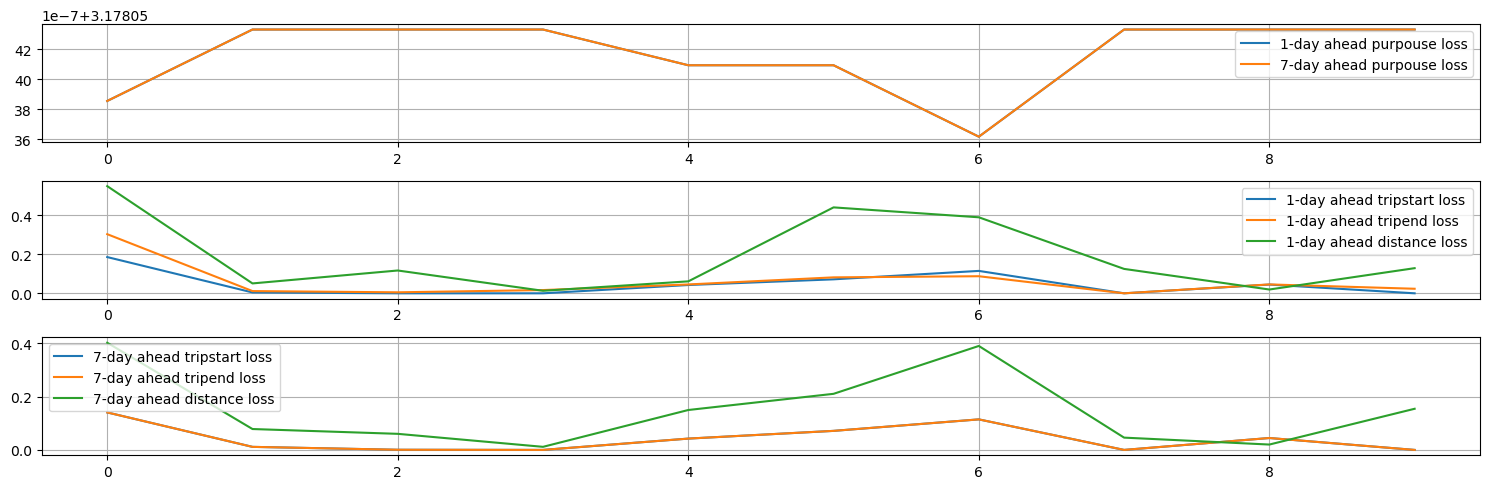

In [ ]:
# Configure basic logging
logging.basicConfig(level=logging.DEBUG, force=True, format='%(levelname)s: %(message)s')

# Tracking gradients
def print_grad(grad):
    logging.inform("Grad", grad)

rnn_model = RNNmodel().to(device)

ce_loss = nn.CrossEntropyLoss(weight=ce_weighting).to(device)  #(y_hat, y)
mse_loss = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.005)

epochs = 1
seq_length = 7
i_to_loop = 10

c1_penalty_weight = 10

for epochi in range(epochs):

    # Collecting losses
    purpouse_loss_for_i_1 = np.zeros(i_to_loop)
    purpouse_loss_for_i_7 = np.zeros(i_to_loop)
    
    tripstart_loss_for_i_1 = np.zeros(i_to_loop)
    tripstart_loss_for_i_7 = np.zeros(i_to_loop)

    tripend_loss_for_i_1 = np.zeros(i_to_loop)
    tripend_loss_for_i_7 = np.zeros(i_to_loop)

    distance_loss_for_i_1 = np.zeros(i_to_loop)
    distance_loss_for_i_7 = np.zeros(i_to_loop)


    #print(epochi)
    for individual_i in range(i_to_loop):
        #print(f"Individual: {individual_i}")

        travel_diary = X[individual_i, :, 0, :].unsqueeze(1).to(torch.float32)
        logging.debug(travel_diary.shape)

        features = X[individual_i, :, 0, 40:].unsqueeze(1).to(torch.float32)

        travel_diary7 = X[individual_i, :7, 0, :].unsqueeze(1).to(torch.float32)

        logging.debug(f"Shape of travel diary: {travel_diary.shape}")

        for i in range(0, travel_diary.shape[0] - seq_length):

            # Conditions of violation

            logging.debug(f"Indexing travel diary from {i} until {seq_length+i}")


            

            sliding_input = travel_diary[i:seq_length+i,0,:].unsqueeze(1)
            logging.debug(f"Sliding input shape: {sliding_input.shape}")
            sliding_input7 = travel_diary7[i:seq_length+i,0,:].unsqueeze(1)


            #masked_outcome_rows = travel_diary[:7,0,:30].unsqueeze(1)
            #logging.debug(masked_outcome_rows.shape) 
            #feature_rows = travel_diary[:,0,30:].unsqueeze(1)
            #logging.debug(feature_rows.shape)

            #print(sliding_input.shape)

            ## 1-AHEAD PREDICTIONS ##

            y_tripstart_pred_1, y_tripend_pred_1, y_distance_pred_1, y_purpouse_pred_1 = rnn_model.forward(sliding_input)
            
            categorical_prediction = torch.argmax(y_purpouse_pred_1, dim=-1)

            y_tripstart_true, y_tripend_true, y_distance_true, y_purpouse_true = y_cont[individual_i,i,:10], y_cont[individual_i,i,10:20], y_cont[individual_i,i,20:], y_cat[individual_i,i,:].long()

            ## 7-AHEAD_PREDICTIONS ##

            y_tripstart_pred_7, y_tripend_pred_7, y_distance_pred_7, y_purpouse_pred_7 = rnn_model.forward(sliding_input7)
            categorical_prediction7 = torch.argmax(y_purpouse_pred_7, dim=-1)

            logging.debug("Predictions pre transform")
            logging.debug(y_tripstart_pred_7.shape)
            logging.debug(y_tripend_pred_7.shape)
            logging.debug(y_distance_pred_7.shape)
            logging.debug(categorical_prediction7.shape)
            # Apending to traveldiary_7
            outcome_pred_7 = torch.cat([y_tripstart_pred_7.reshape(1,1,-1), 
                                        y_tripend_pred_7.reshape(1,1,-1), 
                                        y_distance_pred_7.reshape(1,1,-1),
                                        categorical_prediction7.reshape(1,1,-1)], dim=-1)
            logging.debug("Predictions post transform")
            logging.debug(outcome_pred_7.shape)
            
            features_7 = features[seq_length+i,:,:].unsqueeze(1)
            logging.debug(f"Features shape: {features_7.shape}")

            outcome_features_7 = torch.cat([outcome_pred_7, features_7], dim=-1)
            logging.debug(f"Outcome+features: {outcome_features_7.shape}")

            travel_diary7 = torch.cat([travel_diary7, outcome_features_7], dim=0)
            logging.debug(f"New travel diary7 shape: {travel_diary7.shape}")

            # What is the model predicting
            logging.info("")
            logging.info(f"categorical ground truth: {y_purpouse_true}")
            logging.info(f"categorical prediction1: {categorical_prediction}")
            logging.info(f"categorical prediction7: {categorical_prediction7}")
            logging.info(f"y_tripstart_pred1: {y_tripstart_pred_1}")
            logging.info(f"y_tripend_pred1: {y_tripend_pred_1}")
            logging.info(f"y_tripstart_pred7: {y_tripstart_pred_7}")
            logging.info(f"y_tripend_pred7: {y_tripend_pred_7}")
            logging.info(f"y_distance_pred1: {y_distance_pred_1}")
            logging.info(f"y_distance_pred7: {y_distance_pred_7}")
            logging.info("")

            # conditions
            c1_1 = torch.clamp(y_tripstart_pred_1 - y_tripend_pred_1, min=0)
            c1_7 = torch.clamp(y_tripstart_pred_7 - y_tripend_pred_7, min=0)

            c1_1_loss = c1_penalty_weight * torch.mean(c1_1)
            c1_7_loss = c1_penalty_weight * torch.mean(c1_7)

            # Compute MSE and CE loss for one-day-ahead of the week

            tripstart_loss1 = mse_loss(y_tripstart_pred_1, y_tripstart_true)
            tripend_loss1 = mse_loss(y_tripend_pred_1, y_tripend_true)
            distance_loss1 = mse_loss(y_distance_pred_1, y_distance_true)
            purpouse_loss1 = ce_loss(y_purpouse_pred_1, y_purpouse_true)

            combined_loss1 = tripstart_loss1 + tripend_loss1 + distance_loss1 + purpouse_loss1 + c1_1_loss

            # Compute MSE and CE loss for one-day-ahead of the week

            tripstart_loss7 = mse_loss(y_tripstart_pred_7, y_tripstart_true)
            tripend_loss7 = mse_loss(y_tripend_pred_7, y_tripend_true)
            distance_loss7 = mse_loss(y_distance_pred_7, y_distance_true)
            purpouse_loss7 = ce_loss(y_purpouse_pred_7, y_purpouse_true)

            combined_loss7 = tripstart_loss7 + tripend_loss7 + distance_loss7 + purpouse_loss7 + c1_7_loss



            
            optimizer.zero_grad()
            combined_loss1.backward()
            optimizer.step()

            #### WARNING - using the 7-day ahead loss to update weights won't work unless I fix up my computational graphs!
            
            
        logging.info(f"epoch: {epochi} | individual: {individual_i+1} | loss 1-ahead: {combined_loss1:2f} | loss 7-ahead: {combined_loss7:2f}")
        logging.info(f"Categorical loss 1-ahead: {purpouse_loss1} | Categorical loss 7-ahead: {purpouse_loss7}")

        purpouse_loss_for_i_1[individual_i] = purpouse_loss1
        purpouse_loss_for_i_7[individual_i] = purpouse_loss7
        
        tripstart_loss_for_i_1[individual_i] = tripstart_loss1
        tripstart_loss_for_i_7[individual_i] = tripstart_loss7

        tripend_loss_for_i_1[individual_i] = tripend_loss1
        tripend_loss_for_i_7[individual_i] = tripstart_loss7

        distance_loss_for_i_1[individual_i] = distance_loss1
        distance_loss_for_i_7[individual_i] = distance_loss7

plt.figure(figsize=(15,5))

plt.subplot(3,1,1)
plt.plot(range(i_to_loop), purpouse_loss_for_i_1, label="1-day ahead purpouse loss")
plt.plot(range(i_to_loop), purpouse_loss_for_i_7, label="7-day ahead purpouse loss")
plt.grid()
plt.legend()

plt.subplot(3,1,2)
plt.plot(range(i_to_loop), tripstart_loss_for_i_1, label="1-day ahead tripstart loss")
plt.plot(range(i_to_loop), tripend_loss_for_i_1, label="1-day ahead tripend loss")
plt.plot(range(i_to_loop), distance_loss_for_i_1, label="1-day ahead distance loss")
plt.grid()
plt.legend()

plt.subplot(3,1,3)
plt.plot(range(i_to_loop), tripstart_loss_for_i_7, label="7-day ahead tripstart loss")
plt.plot(range(i_to_loop), tripend_loss_for_i_7, label="7-day ahead tripend loss")
plt.plot(range(i_to_loop), distance_loss_for_i_7, label="7-day ahead distance loss")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

    
